In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import glob
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from IPython.display import clear_output
import math

In [50]:
from sklearn.cluster import KMeans #import a random package to avoid kernel death when using pyplot (makes no sense but works)

<font size="5">Preprocessing

In [51]:
def extractLabels(file):
    
    
    backup = file
    if 'nan' in file:
        #print(backup)
        return None
    file = file.split("\\")[1]
    file = file.split("_", 16)
    file[16] = file[16].split('.', 1)[0]
    #remove useless labels
    del file[16] #'Random string'
    del file[15] #'Body Style'
    del file[14] #'Passenger Doors',
    del file[13] #'Passenger Capacity'
    del file[12] #'Drivetrain'
    del file[11] #'Gas Mileage'
    #del file[10] #'Length, Overall (in)'
    del file[9] #'Height, Overall (in)'
    del file[8] #'Width, Max w/o mirrors (in)'
    del file[7] #'Engine Type'
    del file[6] #'Displacement'
    del file[5] #'SAE Net Horsepower @ RPM'
    del file[4] #'Front Wheel Size (in)'
    del file[3] #'MSRP' Prix
    del file[2] #'Year'
    del file[1] #'Model'
    del file[0]#Make'
    
    try:
        file = [int(float(i)) for i in file]
    except Exception as e: #get name of file who raises an error
        print(backup)
        return None
    return file

In [52]:
def Normalize_labels(labels):
    for i in range(labels.shape[1]):
        minimum = labels[:,i].min()
        maximum = labels[:,i].max()
        print(minimum, maximum)
        for j in range(labels.shape[0]):
            labels[j,i] = (labels[j,i] - minimum)/(maximum - minimum)
    return labels            

In [53]:
num = 3000
tensorLab_list = []
None_id = []
i = 0

for filename in glob.glob('Data/Cars/*.jpg'):
    labels = extractLabels(filename)
    if labels != None:
        tensorLab_list.append(torch.FloatTensor(labels))
    else: None_id.append(i)
    i += 1
    #if i >= num: break
LabelsTens = torch.stack(tensorLab_list)
LabelsTens = Normalize_labels(LabelsTens)

Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_acT.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_aDk.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_ArO.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_buM.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_cMm.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_CNE.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_CnK.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_eey.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_EjM.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_eQB.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_FZl.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_gEI.jpg
Data/Cars\Cadillac_XTS_2013_49_18_300_36_6_72_59_- T_17_FWD_5_4_4dr_gFU.jpg
Data/Cars\Ca

In [54]:
print(LabelsTens.shape)
print(LabelsTens)

torch.Size([52427, 1])
tensor([[0.5489],
        [0.5489],
        [0.5489],
        ...,
        [0.6617],
        [0.6617],
        [0.6617]])


Distribution of the normalized labels

<BarContainer object of 31 artists>

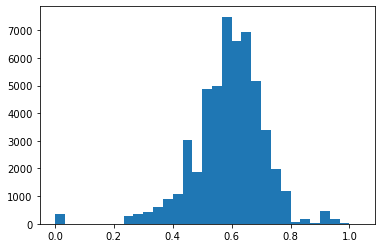

In [55]:
plt.hist(LabelsTens.view(-1).tolist(), np.arange(0,1+1/30,1/30))[2]

In [61]:
num = 3000
image_size = 128
total_files = 64467
current_perc = 0

tensorIm_list = []
i = 0

transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()])

for filename in glob.glob('Data/Cars/*.jpg'):
    image=Image.open(filename)
    image = transform(image)
    if(i not in None_id): tensorIm_list.append(image)
    if math.floor(i/total_files*100) > current_perc:
        current_perc += 1
        s = '[' + '-'*current_perc + str(current_perc+1) + '%' + ' '*(99-current_perc)+ ']'
        print('       ----------------------------------------Loading Data----------------------------------------', '\n', s)
        clear_output(wait=True)
        
        
    i += 1
    #if i >= num: break
CarsTens = torch.stack(tensorIm_list)

       ----------------------------------------Loading Data---------------------------------------- 
 [---------------------------------------------------------------------------------------------------100%]


In [62]:
print(CarsTens.shape)

torch.Size([52427, 3, 128, 128])


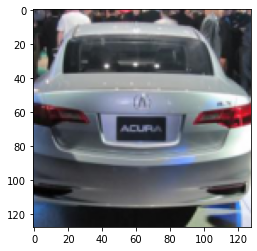

In [63]:
plt.imshow(CarsTens[0].permute(1,2,0))

Seperation dataset into train/test with 80/20% ratio

In [64]:
nb_images = CarsTens.shape[0]
nb_im_train = int(nb_images*.8)

ids = np.arange(nb_images)
train_ids = np.random.choice(ids, nb_im_train, replace = False)
test_ids = np.array([i for i in ids if i not in train_ids])

In [65]:
print(f"ids: {ids.shape[0]} \ntrain_ids: {train_ids.shape[0]} \ntest_ids: {test_ids.shape[0]}")

ids: 52427 
train_ids: 41941 
test_ids: 10486


In [66]:
class Train_Dataset_Embed(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return train_ids.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        idx = train_ids[index]
        X = CarsTens[index]
        y = LabelsTens[index]

        return X, y

In [67]:
batch_size = 64

dl = Train_Dataset_Embed()
train_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(train_loader))
print(test[0].shape)

torch.Size([64, 3, 128, 128])


In [68]:
class Test_Dataset_Embed(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return test_ids.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        idx = test_ids[index]
        X = CarsTens[index]
        y = LabelsTens[index]

        return X, y

In [69]:
batch_size = 256

dl = Test_Dataset_Embed()
test_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(test_loader))
print(test[0].shape)

torch.Size([256, 3, 128, 128])


<font size="5">Embedding:

-train a classifier Image->feature <br>
-use the linear part dim_embed->1 to train the embeding network y2h with MSE loss on recronstruction

In [70]:
NC = 3
IMG_SIZE = 128
DIM_EMBED = 128

In [71]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes: #if True we add a residual part to the block
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_embed(nn.Module):
    def __init__(self, block, num_blocks, nc=NC, dim_embed=DIM_EMBED):
        super(ResNet_embed, self).__init__()
        self.in_planes = 64

        self.main = nn.Sequential(
            nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False),  # h=h
            # nn.Conv2d(nc, 64, kernel_size=4, stride=2, padding=1, bias=False),  # h=h/2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #h=h/2 64
            # self._make_layer(block, 64, num_blocks[0], stride=1),  # h=h
            self._make_layer(block, 64, num_blocks[0], stride=2),  # h=h/2 32
            self._make_layer(block, 128, num_blocks[1], stride=2), # h=h/2 16
            self._make_layer(block, 256, num_blocks[2], stride=2), # h=h/2 8
            self._make_layer(block, 512, num_blocks[3], stride=2), # h=h/2 4
            # nn.AvgPool2d(kernel_size=4)
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.x2h_res = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, dim_embed),
            nn.BatchNorm1d(dim_embed),
            nn.ReLU(),
        )

        self.h2y = nn.Sequential(
            nn.Linear(dim_embed, 1),
            nn.ReLU()
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        features = self.main(x)
        features = features.view(features.size(0), -1)
        features = self.x2h_res(features)
        out = self.h2y(features)

        return out, features

In [72]:
def ResNet18_embed(dim_embed=DIM_EMBED):
    return ResNet_embed(BasicBlock, [2,2,2,2], dim_embed=dim_embed)
def ResNet34_embed(dim_embed=DIM_EMBED):
    return ResNet_embed(BasicBlock, [3,4,6,3], dim_embed=dim_embed)

#after testing ResNet18 gives the lowest loss -> better model

Training of CNN Regressor

In [73]:
#testing the forward of the network

net = ResNet18_embed()

img, lab = next(iter(train_loader))
out = net(img)

print(out[0].shape)

torch.Size([64, 1])


In [74]:
def adjust_learning_rate_1(optimizer, epoch):
        """decrease the learning rate """
        lr = lr_base

        num_decays = len(lr_decay_epochs)
        for decay_i in range(num_decays):
            if epoch >= lr_decay_epochs[decay_i]:
                lr = lr * lr_decay_factor
            #end if epoch
        #end for decay_i
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [75]:
#hyperparameters

device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 200
lr_base = 0.01
lr_decay_epochs = [80,140]
lr_decay_factor = 0.1
net = ResNet18_embed().to(device).float()
net = nn.DataParallel(net)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr_base)

#train loop

for ep in range(epochs):
    net.train()
    adjust_learning_rate_1(optimizer, ep)
    optimizer.zero_grad()
    imgs, labels = next(iter(train_loader))
    out , _ = net(imgs.to(device))
    lossT = criterion(out, labels)
    lossT.backward()
    optimizer.step()
    
    if ep%5 == 4:
        net.eval()
        imgs, labels = next(iter(test_loader))
        out, _ = net(imgs.to(device))
        lossV = criterion(out, labels)
        print(f"epoch n{ep}: \nTrain loss: {lossT}      Test loss: {lossV}")
        print(out[:10])
        print(labels[:10])
        

epoch n4: 
Train loss: 0.08261865377426147      Test loss: 262118146048.0
tensor([[703579.9375],
        [924130.4375],
        [217969.3906],
        [369980.3750],
        [287719.9688],
        [649345.3125],
        [411843.3438],
        [547845.0625],
        [823833.9375],
        [273085.2500]], grad_fn=<SliceBackward>)
tensor([[0.6466],
        [0.6241],
        [0.4962],
        [0.4962],
        [0.5714],
        [0.5714],
        [0.4511],
        [0.5714],
        [0.5113],
        [0.6316]])
epoch n9: 
Train loss: 0.07030686736106873      Test loss: 411149952.0
tensor([[ 4463.7695],
        [10628.9570],
        [22005.6699],
        [10605.7588],
        [21100.5781],
        [ 7569.6680],
        [20046.7246],
        [10259.8896],
        [13237.1240],
        [17792.3809]], grad_fn=<SliceBackward>)
tensor([[0.6316],
        [0.5940],
        [0.6241],
        [0.6015],
        [0.4737],
        [0.6241],
        [0.6767],
        [0.6541],
        [0.5489],
        [0

In [23]:
#saving network

PATH = "models/embed/embed128.pth"
torch.save({
                    'epoch': ep,
                    'net_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'rng_state': torch.get_rng_state()
            }, PATH)

Testing loading of h2y part

In [24]:
PATH = "models/embed/embed128.pth"

test = ResNet18_embed()
test = nn.DataParallel(test)

cp = torch.load(PATH)
test.load_state_dict(cp['net_state_dict'])

print(test.module.h2y)

Sequential(
  (0): Linear(in_features=128, out_features=1, bias=True)
  (1): ReLU()
)


<font size="5">Inversion of h2y layer

In [25]:
class labels_Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return ids.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        y = LabelsTens[index]

        return y

In [26]:
class model_y2h(nn.Module):
    def __init__(self, dim_embed=DIM_EMBED):
        super(model_y2h, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            nn.ReLU()
        )

    def forward(self, y):
        y = y.view(-1, 1) +1e-8
        # y = torch.exp(y.view(-1, 1))
        return self.main(y)

Testing forward of y2h

In [27]:
y2h = model_y2h()

test = torch.rand(1)
out = y2h.forward(test)

print(out.shape)

torch.Size([1, 128])


Training of the y2h model

In [41]:
batch_size = 128
lr_base = 0.01
weight_decay = 1e-4
lr_decay_factor=0.1 
lr_decay_epochs=[150, 250, 350]
epochs = 500

device = "cuda" if torch.cuda.is_available() else "cpu"

def adjust_learning_rate_2(optimizer, epoch):
        """decrease the learning rate """
        lr = lr_base

        num_decays = len(lr_decay_epochs)
        for decay_i in range(num_decays):
            if epoch >= lr_decay_epochs[decay_i]:
                lr = lr * lr_decay_factor
            #end if epoch
        #end for decay_i
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
trainset = labels_Dataset()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

PATH = "models/embed/embed128.pth"

net_embed = ResNet18_embed()
net_embed = nn.DataParallel(net_embed)

cp = torch.load(PATH)
net_embed.load_state_dict(cp['net_state_dict'])

net_embed.eval()
net_h2y = net_embed.module.h2y #convert embedding labels to original labels
net_y2h = model_y2h()
optimizer_y2h = torch.optim.SGD(net_y2h.parameters(), lr = lr_base, momentum= 0.9, weight_decay=weight_decay)

for ep in range(epochs):
    net_y2h.train()
    adjust_learning_rate_2(optimizer_y2h, ep)
    
    labels = next(iter(trainloader)).type(torch.float).to(device)
    batch_size_curr = len(labels)
    batch_gamma = torch.normal(0, 0.2, size = (batch_size_curr, 1))
    labels_noised = torch.clamp(labels + batch_gamma, 0.0, 1.0)
    
    #plt.hist(labels_noised.view(-1).tolist())
    
    out = net_y2h(labels_noised)
    labels_noised_rec = net_h2y(out)
    
    loss = nn.MSELoss()(labels_noised_rec, labels_noised) #tester L1 loss
    optimizer_y2h.zero_grad()
    loss.backward()
    optimizer_y2h.step()
    
    if(ep%15 == 0):
        print(f"epoch n{ep}: \nTrain loss: {loss}")

epoch n0: 
Train loss: 0.09654431790113449
epoch n15: 
Train loss: 0.10417551547288895
epoch n30: 
Train loss: 0.12101885676383972
epoch n45: 
Train loss: 0.1068544089794159
epoch n60: 
Train loss: 0.10122402012348175
epoch n75: 
Train loss: 0.07765977829694748
epoch n90: 
Train loss: 0.09468379616737366
epoch n105: 
Train loss: 0.1006588414311409
epoch n120: 
Train loss: 0.10449202358722687
epoch n135: 
Train loss: 0.06950400024652481
epoch n150: 
Train loss: 0.09300600737333298
epoch n165: 
Train loss: 0.0713677629828453
epoch n180: 
Train loss: 0.09308579564094543
epoch n195: 
Train loss: 0.1127459853887558
epoch n210: 
Train loss: 0.07661470770835876
epoch n225: 
Train loss: 0.0902479737997055
epoch n240: 
Train loss: 0.07269657403230667
epoch n255: 
Train loss: 0.08630093932151794
epoch n270: 
Train loss: 0.08968424797058105
epoch n285: 
Train loss: 0.11518796533346176
epoch n300: 
Train loss: 0.07676295191049576
epoch n315: 
Train loss: 0.07856746762990952
epoch n330: 
Train loss

In [42]:
#saving network

PATH = "models/y2h/y2h128.pth"
torch.save({
                    'epoch': ep,
                    'net_state_dict': net_y2h.state_dict(),
                    'optimizer_state_dict': optimizer_y2h.state_dict(),
                    'rng_state': torch.get_rng_state()
            }, PATH)

Testing of data embedding inversability

Text(0.5, 1.0, 'distribution of labels with an error > 0.015')

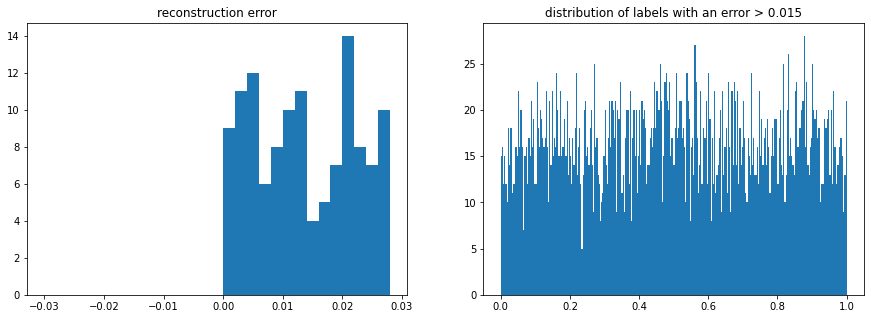

In [43]:
PATH = "models/embed/embed128.pth"

net_embed = ResNet18_embed()
net_embed = nn.DataParallel(net_embed)

cp = torch.load(PATH)
net_embed.load_state_dict(cp['net_state_dict'])

net_h2y = net_embed.module.h2y

PATH = "models/y2h/y2h128.pth"

net_y2h = model_y2h()
cpy = torch.load(PATH)
net_y2h.load_state_dict(cpy['net_state_dict'])

test = torch.rand(size = (5000,1))
test_h = net_y2h(test)
test_rec = net_h2y(test_h)

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#mettre valeur absolue L2 ?
ax.hist((test - test_rec).view(-1).tolist(), np.arange(-0.03,0.03,(0.03*2)/30))[2]
ax.set_title('reconstruction error')


ax2.hist(test[abs(test - test_rec) > 0.001].view(-1).tolist(), np.arange(0.0,1.0+1/300,1/300))[2]
ax2.set_title('distribution of labels with an error > 0.015')

The y2h model is very efficient at inversing the mapping 128 -> 1 of the net_embed.module.h2y layer <br>
We also see that most of the error comes from the edge cases which are not common in the dataset (cf hist of labels distribution)